# Battle of the Neighborhoods: Toronto
## Week 2

### Introduction 
Toronto is the single most populous city in Canada with an overall population of over 2.7 million residents. This large population is certainly attractive for businesses who are looking to expand into new territory. Unfortunately, this leads to a saturated market for most industries which makes it more difficult for new companies to gain traction. 

The purpose of this project is to analyze the city of Toronto to identify a location that provides the best chances of success for an independent sandwich shop to gain traction.  

### Data
If this project is to be successful we will need to rely on various sources for data. We will need to identify the postal codes, geographical coordinates, venue classifications, and characteristics of the population of Toronto. 

### Methodology
* Scrape wikipedia (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) to generate a data frame with the Postal Codes, Borough Name, and Neighborhood Name
* Generate a second dataframe pulling data from https://cocl.us/Geospatial_data containing the Postal Code and geographical coordinates for each. 
* Next we will merge the above dataframes to link the geographical coordinates with the borough and neighborhood names. 
* We will make requests through the FourSquare API to pull venue data including the names, locations, and classification for venues within Toronto. 
* Neighborhood characteristics detailing population and income will be pulled from a publically available dataset from https://open.toronto.ca/dataset/neighbourhood-profiles/.

In [2]:
#Import Required Libraries and packages
!pip install pandas
import pandas as pd
import numpy as np
import json
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests
!pip install folium==0.5.0
import folium
import xml
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
!pip install geopy
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
print('Libraries installed!')

Libraries installed!


In [3]:
#Set variables
CLIENT_ID = '2FB3NOTCLTMD1TQM5SJXKFETRMYDYOKSMKO3YQO1XK1RDNWE'
CLIENT_SECRET = 'FEWNQWMDUQ1P2XQ3L2XFSJDBB1AQBA01O5Q3NXFY4F20GAR1'
ACCESS_TOKEN = 'JDV1VPK4PMLY4SLTMJMWCJ4BHD34F1KK2DZMD3B4EVQ4OSAE'
VERSION = '20180604'
url=requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup=BeautifulSoup(url,'lxml')
coord_url = "https://cocl.us/Geospatial_data"
LIMIT = 100
radius = 500

In [4]:
def venuesearch(names, latitude, longitude, radius=500):
    venuelist=[]
    for name, lat, lng in zip(names, latitude, longitude):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venuelist.append([(
            name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results]
        )
        
    venues = pd.DataFrame([item for venuelist in venuelist for item in venuelist])
    venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(venues)

def get_venues(lat,lng):
    radius = 400
    LIMIT = 100
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
print(table_contents)

[{'PostalCode': 'M3A', 'Borough': 'North York', 'Neighborhood': 'Parkwoods'}, {'PostalCode': 'M4A', 'Borough': 'North York', 'Neighborhood': 'Victoria Village'}, {'PostalCode': 'M5A', 'Borough': 'Downtown Toronto', 'Neighborhood': 'Regent Park, Harbourfront'}, {'PostalCode': 'M6A', 'Borough': 'North York', 'Neighborhood': 'Lawrence Manor, Lawrence Heights'}, {'PostalCode': 'M7A', 'Borough': "Queen's Park", 'Neighborhood': 'Ontario Provincial Government'}, {'PostalCode': 'M9A', 'Borough': 'Etobicoke', 'Neighborhood': 'Islington Avenue'}, {'PostalCode': 'M1B', 'Borough': 'Scarborough', 'Neighborhood': 'Malvern, Rouge'}, {'PostalCode': 'M3B', 'Borough': 'North York', 'Neighborhood': 'Don Mills North'}, {'PostalCode': 'M4B', 'Borough': 'East York', 'Neighborhood': 'Parkview Hill, Woodbine Gardens'}, {'PostalCode': 'M5B', 'Borough': 'Downtown Toronto', 'Neighborhood': 'Garden District, Ryerson'}, {'PostalCode': 'M6B', 'Borough': 'North York', 'Neighborhood': 'Glencairn'}, {'PostalCode': 'M9

In [6]:
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [7]:
df.shape

(103, 3)

In [8]:
df_coord = pd.read_csv(coord_url)
df_coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
df_coord.columns = ['PostalCode', 'Latitude', 'Longitude']
merge_df = pd.merge(df, df_coord, on = 'PostalCode')
merge_df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [10]:
merge_df.shape

(103, 5)

In [11]:
geolocator = Nominatim(user_agent="drennoj@gmail.com", timeout=30)
location = geolocator.geocode('Toronto, Ontario')
latitude = location.latitude
longitude = location.longitude
print("Toronto's coordinates are {}, {}.".format(latitude, longitude))

Toronto's coordinates are 43.6534817, -79.3839347.


In [12]:
torontomap = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(merge_df['Latitude'], merge_df['Longitude'], merge_df['Borough'], merge_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3199cc',
        fill_opacity=0.3,
        parse_html=False).add_to(torontomap)  
    
torontomap

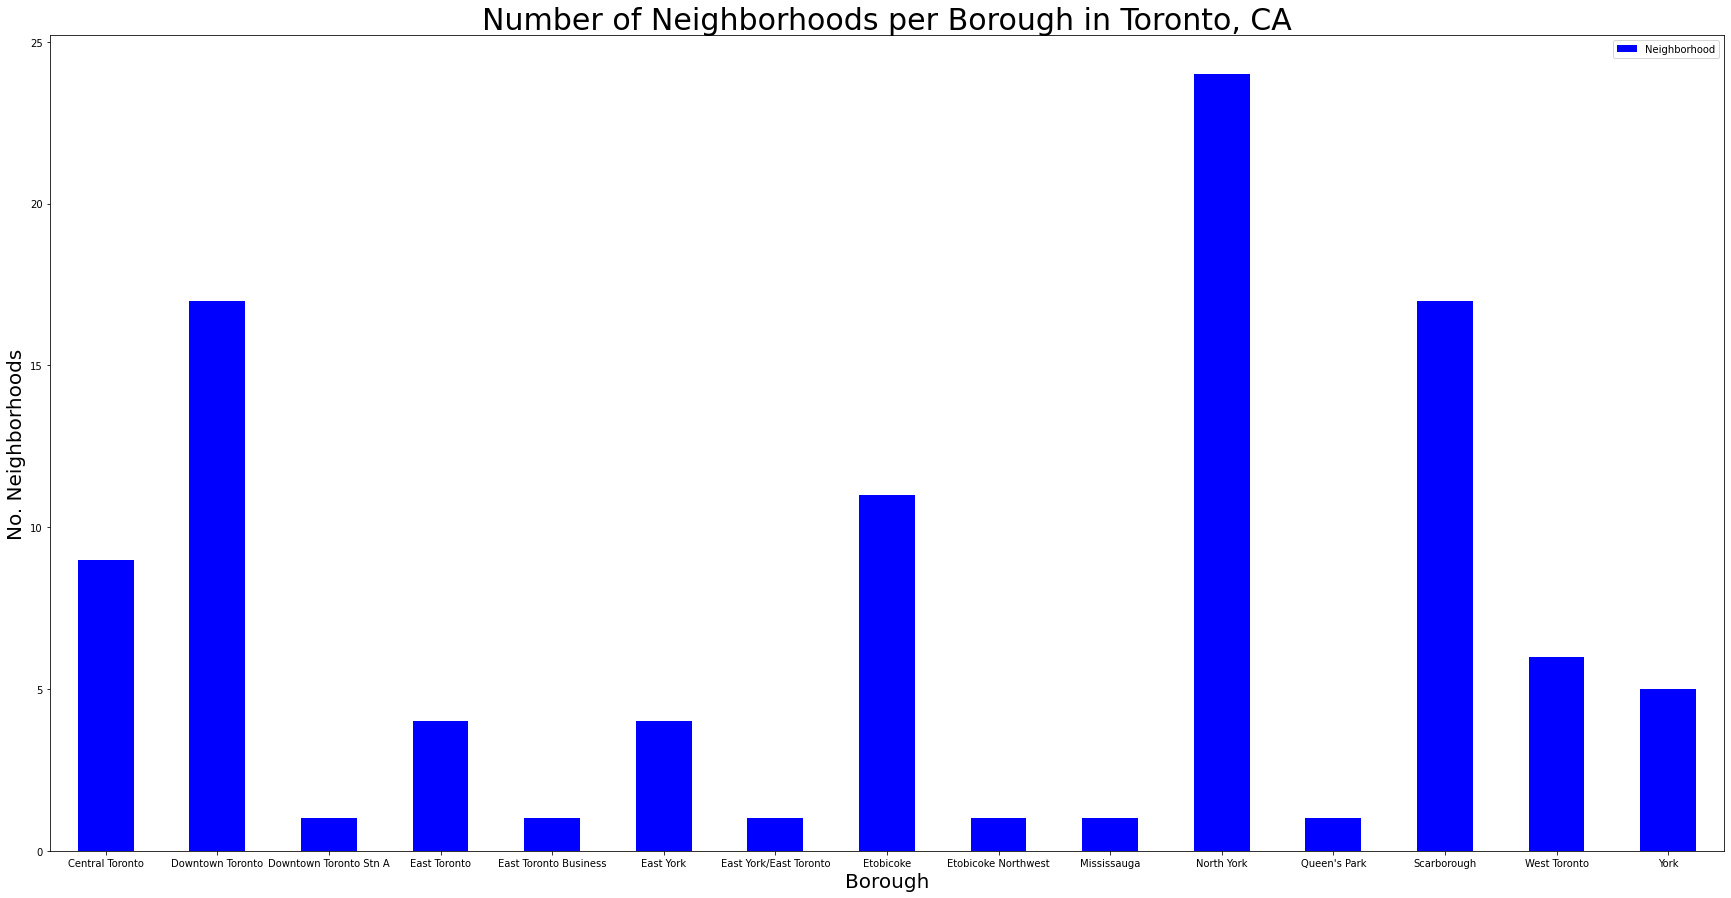

In [14]:
clr = "blue"
merge_df.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(30,15), color=clr)
plt.title('Number of Neighborhoods per Borough in Toronto, CA', fontsize = 30)
plt.xlabel('Borough', fontsize = 20)
plt.ylabel('No. Neighborhoods',fontsize = 20)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [192]:
tvenues = venuesearch(merge_df['Neighborhood'], merge_df['Latitude'], merge_df['Longitude'])
tvenues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Parkwoods,43.753259,-79.329656,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
5,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
6,Victoria Village,43.725882,-79.315572,Eglinton Ave E & Sloane Ave/Bermondsey Rd,43.726086,-79.313620,Intersection
7,Victoria Village,43.725882,-79.315572,Pizza Nova,43.725824,-79.312860,Pizza Place
8,"Regent Park, Harbourfront",43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
9,"Regent Park, Harbourfront",43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop


In [193]:
tvenues.shape

(2113, 7)

In [194]:
column_names=['PostalCode', 'Borough', 'Neighborhood', 'ID','Name']
tvenues=pd.DataFrame(columns=column_names)
count=1
for row in merge_df.values.tolist():
    PostalCode, Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    sandwich_shops=venues[venues['Category']==('Sandwich Place' or 'Deli / Bodega')]   
    print('(',count,'/',len(merge_df),')','Sandwich Shops in '+Neighborhood+', '+Borough+':'+str(len(sandwich_shops)))
    print(row)
    for resturant_detail in sandwich_shops.values.tolist():
        id, name , category=resturant_detail
        tvenues = tvenues.append({'PostalCode': PostalCode, 'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 103 ) Sandwich Shops in Parkwoods, North York:0
['M3A', 'North York', 'Parkwoods', 43.7532586, -79.3296565]
( 2 / 103 ) Sandwich Shops in Victoria Village, North York:0
['M4A', 'North York', 'Victoria Village', 43.725882299999995, -79.31557159999998]
( 3 / 103 ) Sandwich Shops in Regent Park, Harbourfront, Downtown Toronto:0
['M5A', 'Downtown Toronto', 'Regent Park, Harbourfront', 43.6542599, -79.3606359]
( 4 / 103 ) Sandwich Shops in Lawrence Manor, Lawrence Heights, North York:0
['M6A', 'North York', 'Lawrence Manor, Lawrence Heights', 43.718517999999996, -79.46476329999999]
( 5 / 103 ) Sandwich Shops in Ontario Provincial Government, Queen's Park:1
['M7A', "Queen's Park", 'Ontario Provincial Government', 43.6623015, -79.3894938]
( 6 / 103 ) Sandwich Shops in Islington Avenue, Etobicoke:0
['M9A', 'Etobicoke', 'Islington Avenue', 43.6678556, -79.53224240000002]
( 7 / 103 ) Sandwich Shops in Malvern, Rouge, Scarborough:0
['M1B', 'Scarborough', 'Malvern, Rouge', 43.806686299999996

( 55 / 103 ) Sandwich Shops in Studio District, East Toronto:0
['M4M', 'East Toronto', 'Studio District', 43.6595255, -79.340923]
( 56 / 103 ) Sandwich Shops in Bedford Park, Lawrence Manor East, North York:2
['M5M', 'North York', 'Bedford Park, Lawrence Manor East', 43.7332825, -79.4197497]
( 57 / 103 ) Sandwich Shops in Del Ray, Mount Dennis, Keelsdale and Silverthorn, York:1
['M6M', 'York', 'Del Ray, Mount Dennis, Keelsdale and Silverthorn', 43.6911158, -79.47601329999999]
( 58 / 103 ) Sandwich Shops in Humberlea, Emery, North York:0
['M9M', 'North York', 'Humberlea, Emery', 43.7247659, -79.53224240000002]
( 59 / 103 ) Sandwich Shops in Birch Cliff, Cliffside West, Scarborough:0
['M1N', 'Scarborough', 'Birch Cliff, Cliffside West', 43.692657000000004, -79.2648481]
( 60 / 103 ) Sandwich Shops in Willowdale South, North York:0
['M2N', 'North York', 'Willowdale South', 43.7701199, -79.40849279999999]
( 61 / 103 ) Sandwich Shops in Downsview Northwest, North York:0
['M3N', 'North York',

( 103 / 103 ) Sandwich Shops in Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West, Etobicoke:1
['M8Z', 'Etobicoke', 'Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West', 43.6288408, -79.52099940000001]


In [195]:
tvenues.shape

(40, 5)

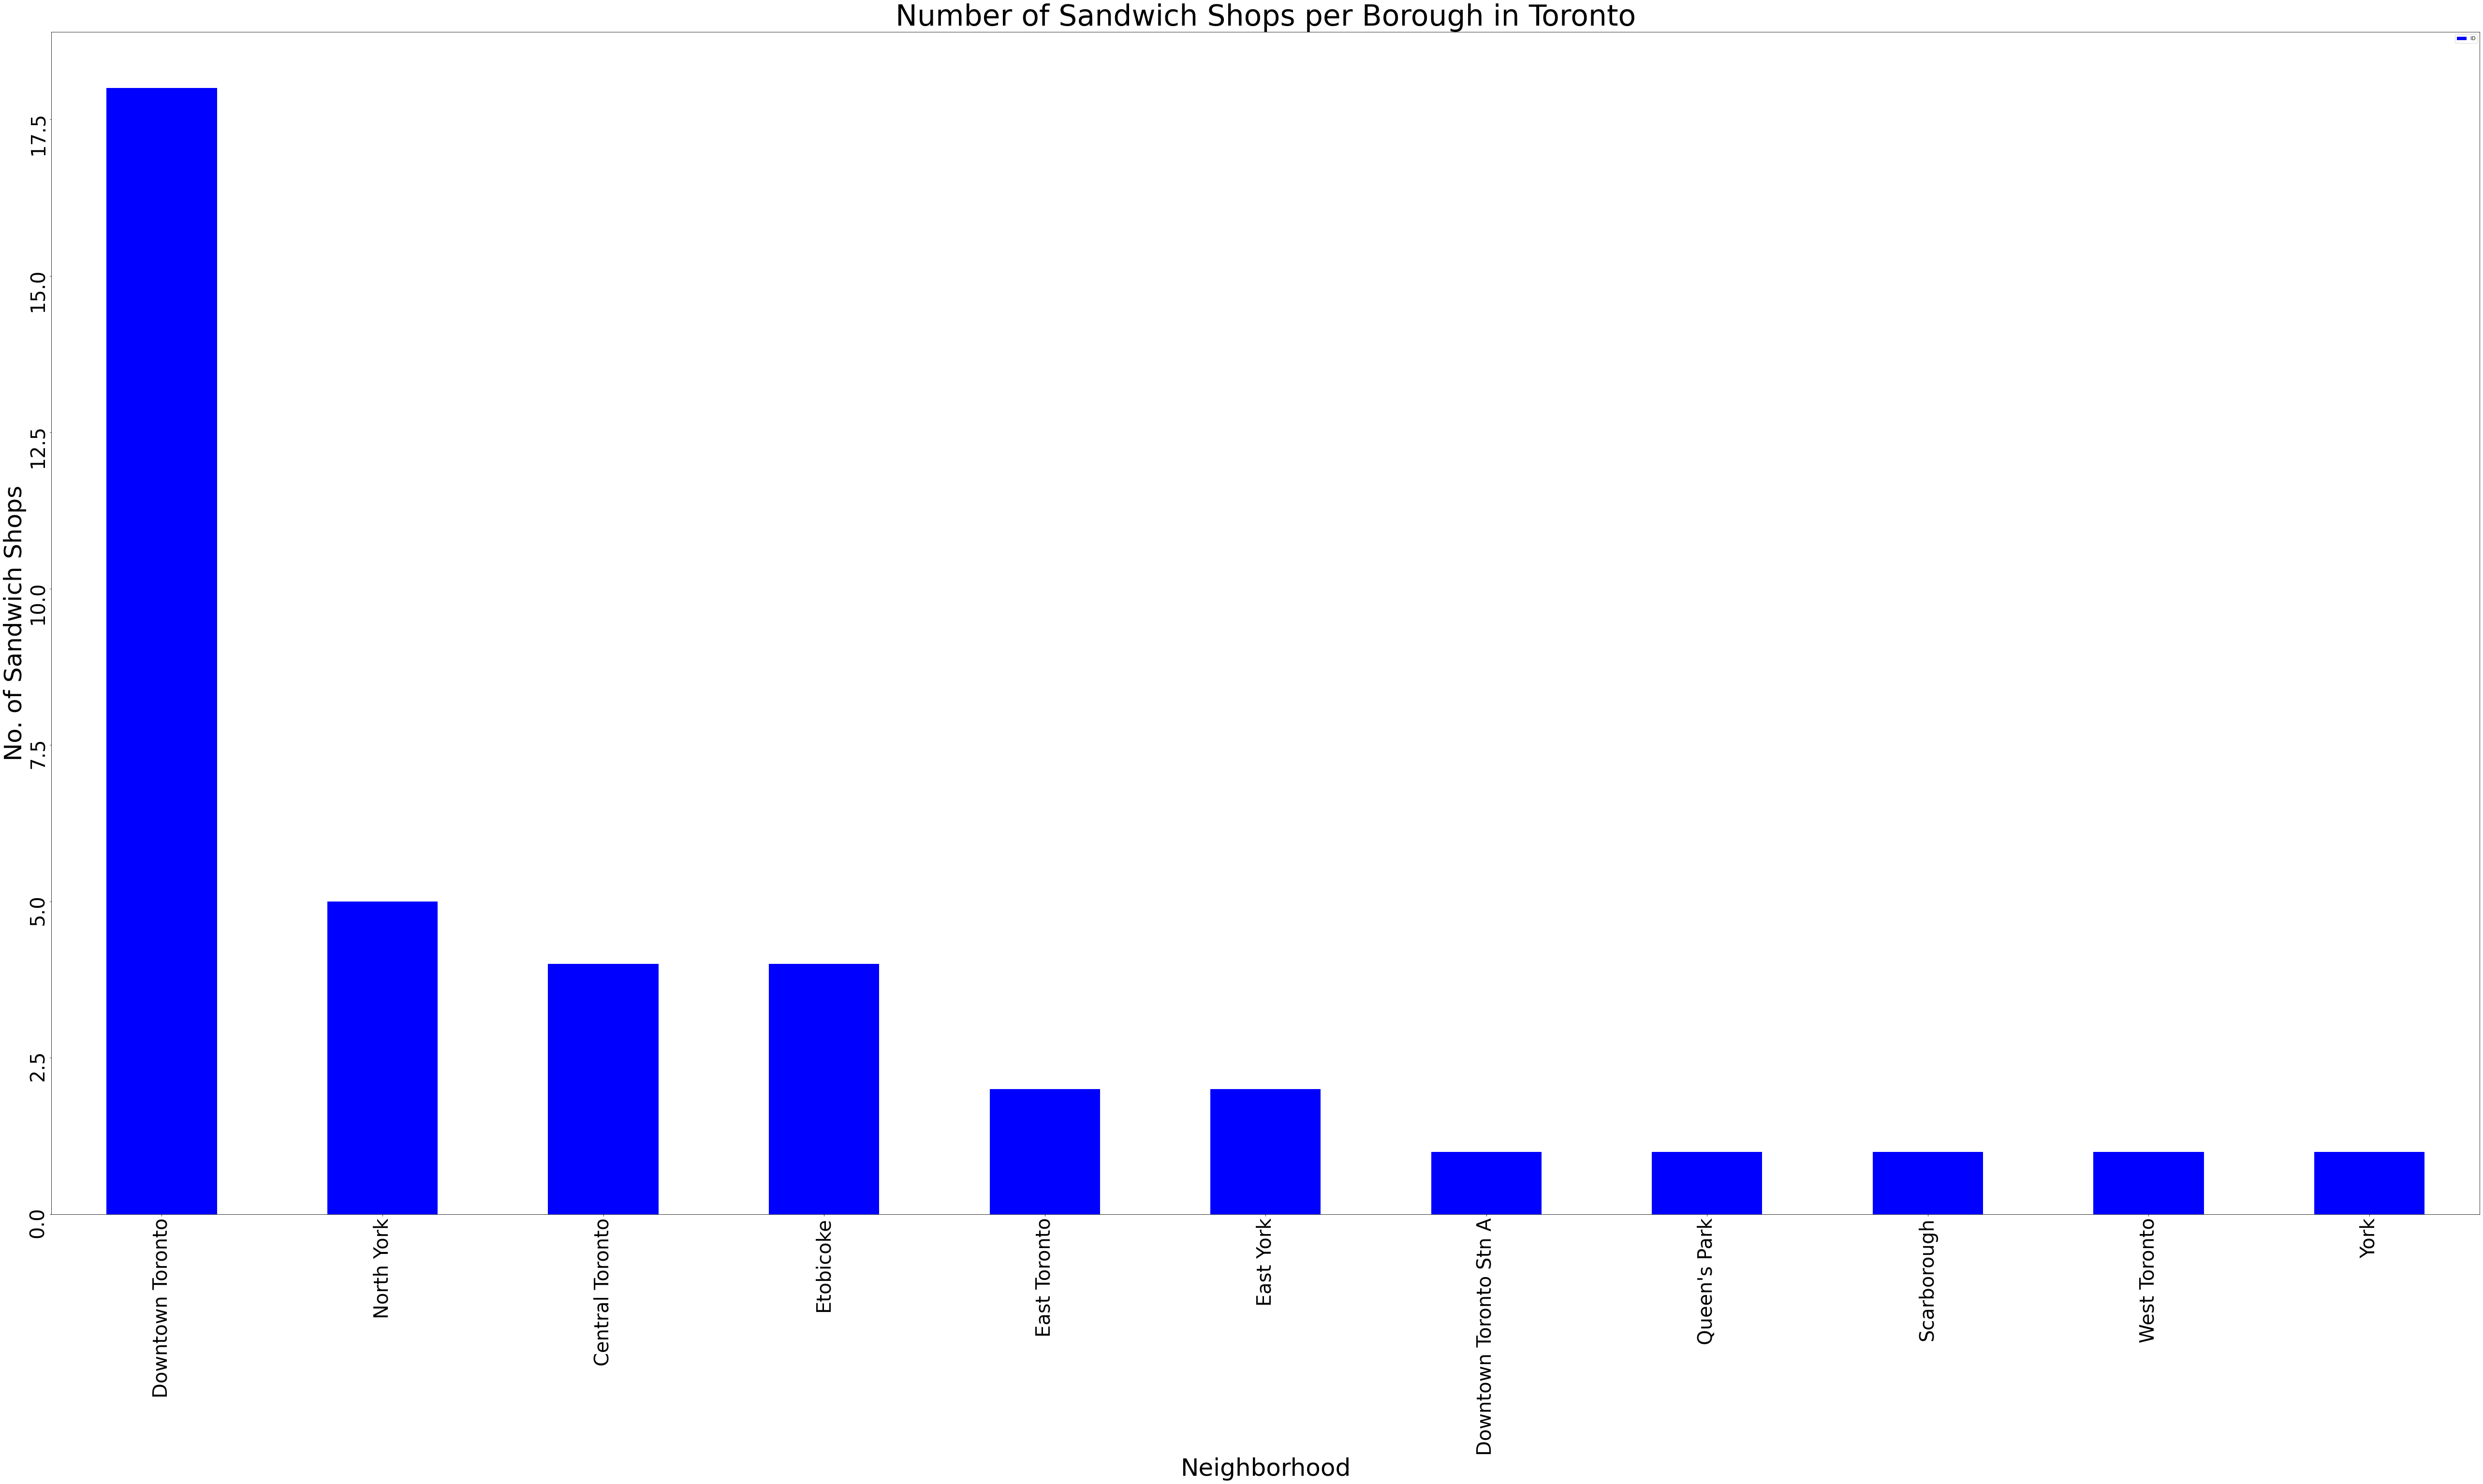

In [480]:
Tor_Neighborhoods = 40 # top number for graphing all the same past 6
tvenues.groupby('Borough')['ID'].count().nlargest(Tor_Neighborhoods).plot.bar(figsize=(90,45), color=clr)
plt.title('Number of Sandwich Shops per Borough in Toronto', fontsize = 60)
plt.xlabel('Neighborhood', fontsize = 50)
plt.ylabel('No. of Sandwich Shops', fontsize=50)
plt.xticks(rotation = 'vertical', fontsize = 40)
plt.yticks(rotation = 'vertical', fontsize = 40)
plt.legend()
plt.show()

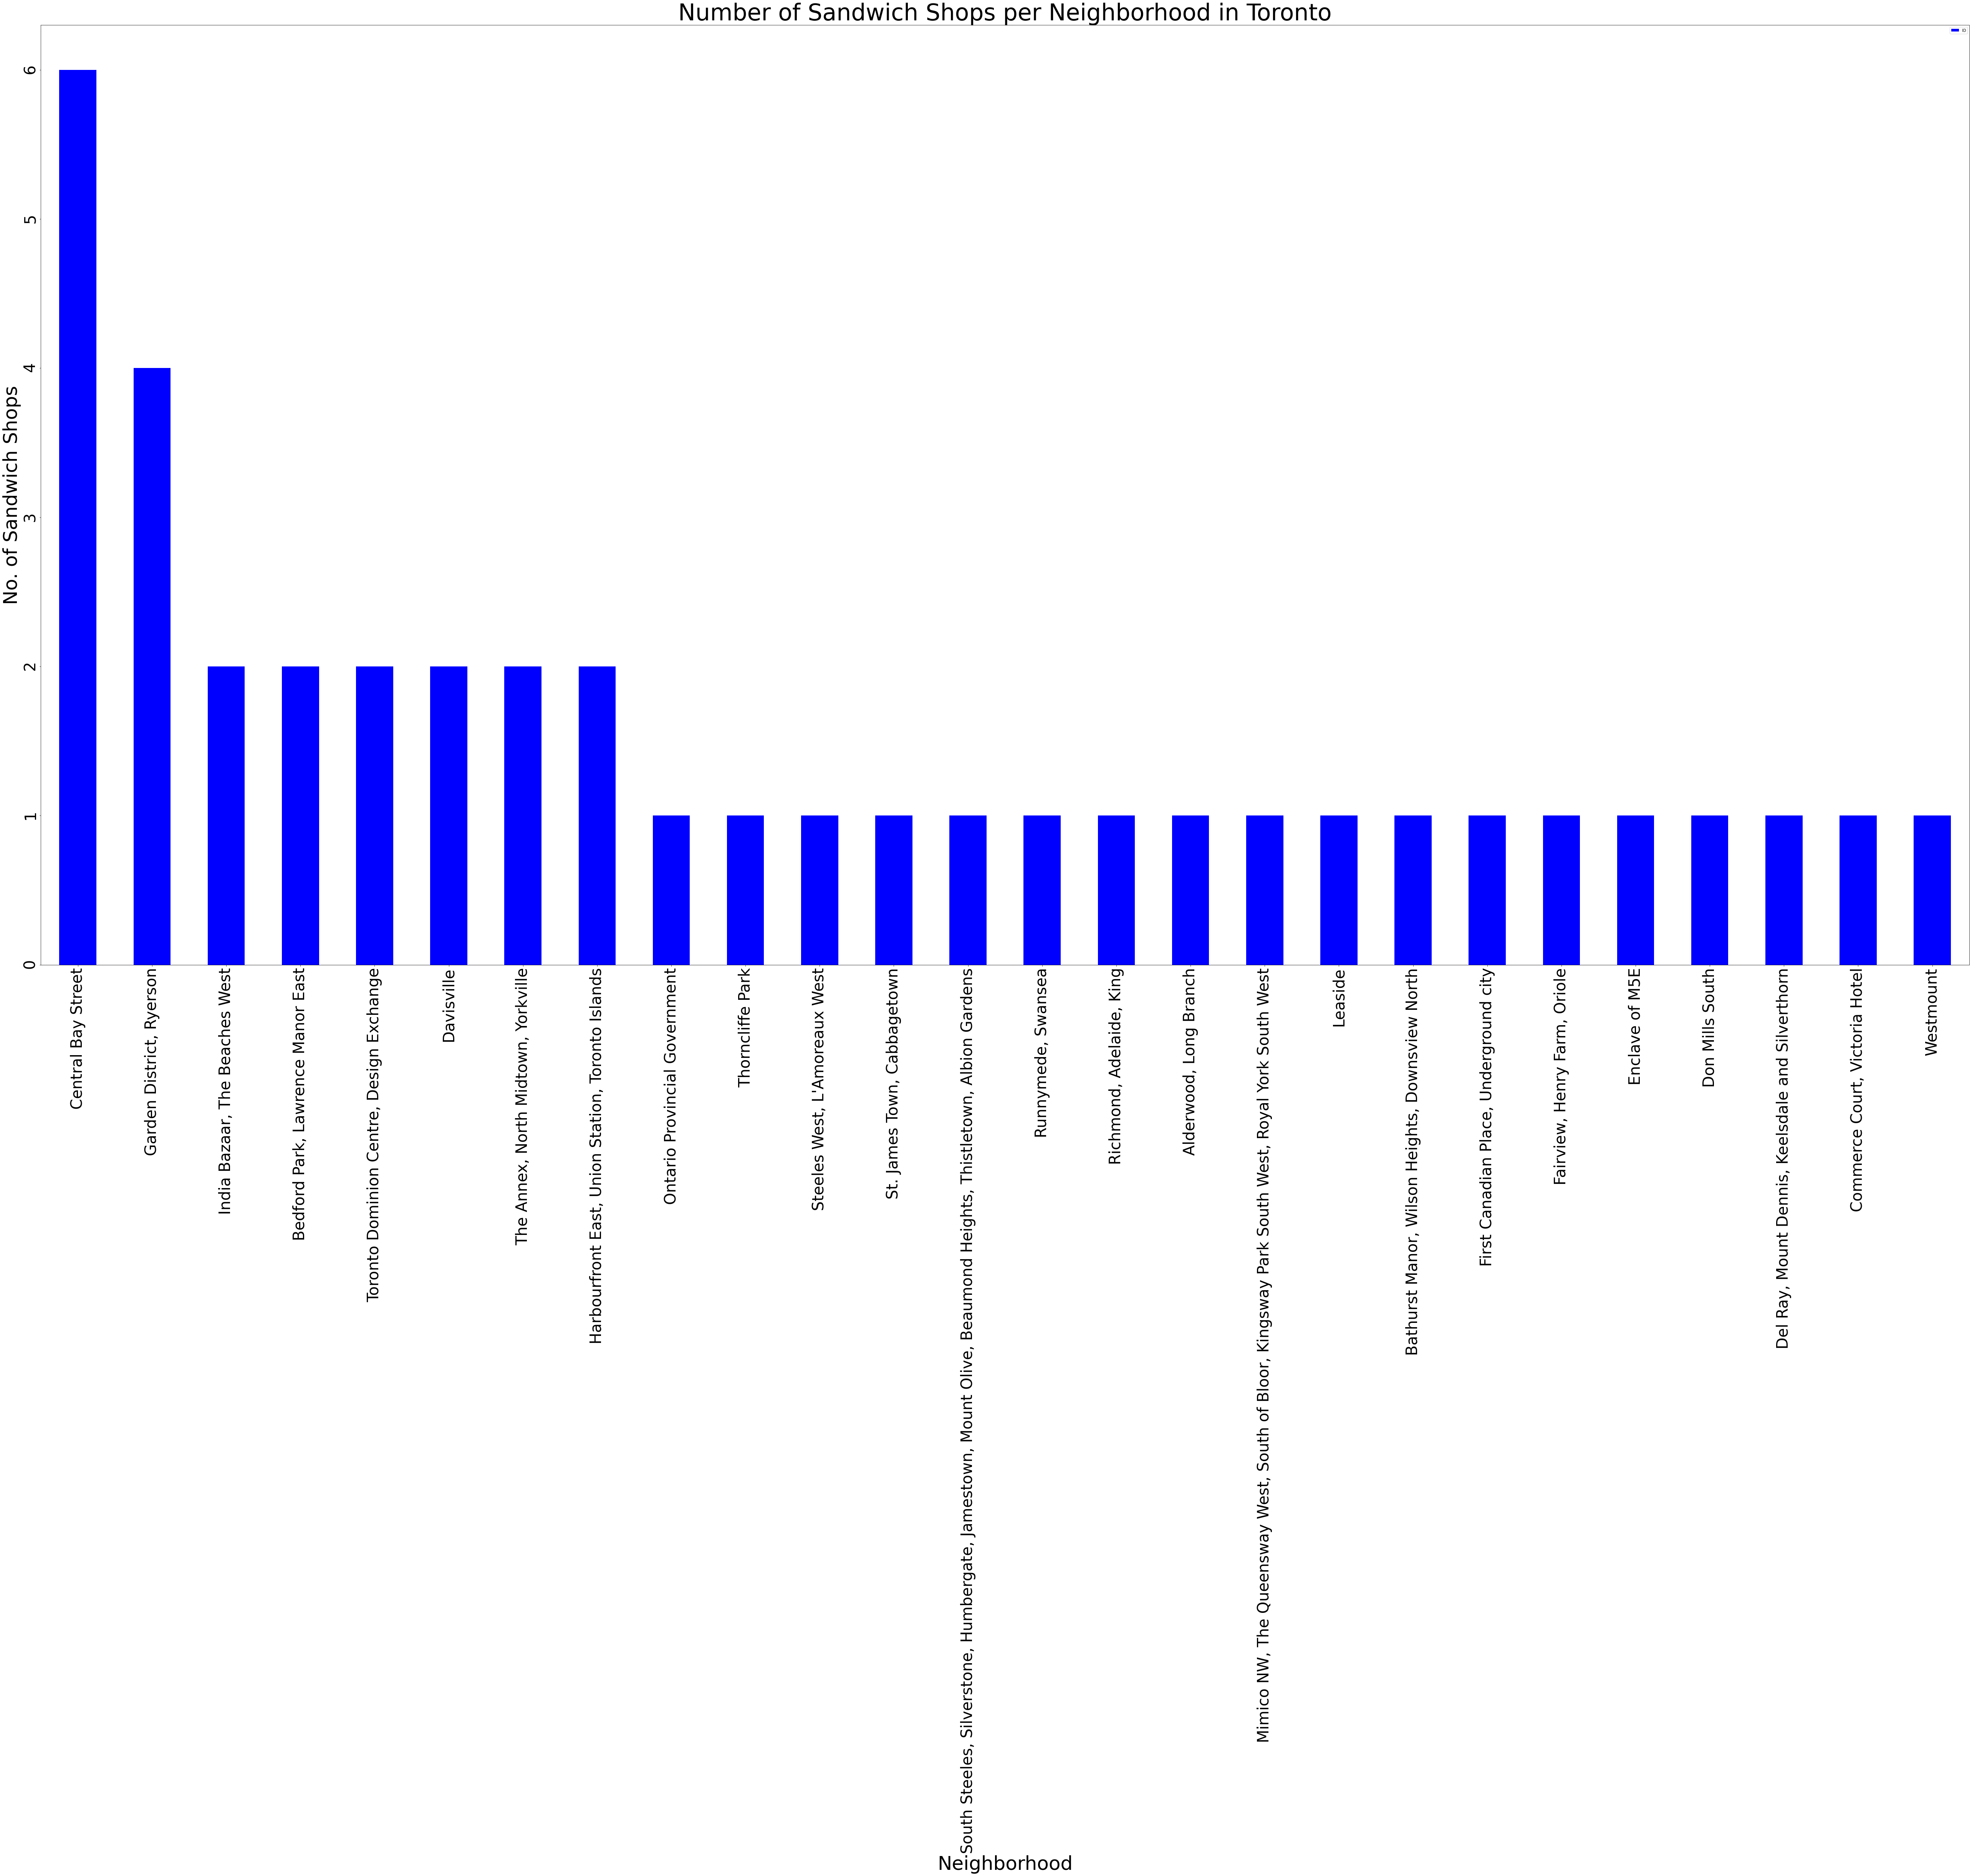

In [197]:
Tor_Neighborhoods = 40 # top number for graphing all the same past 6
tvenues.groupby('Neighborhood')['ID'].count().nlargest(Tor_Neighborhoods).plot.bar(figsize=(90,45), color=clr)
plt.title('Number of Sandwich Shops per Neighborhood in Toronto', fontsize = 60)
plt.xlabel('Neighborhood', fontsize = 50)
plt.ylabel('No. of Sandwich Shops', fontsize=50)
plt.xticks(rotation = 'vertical', fontsize = 40)
plt.yticks(rotation = 'vertical', fontsize = 40)
plt.legend()
plt.show()

In [462]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [463]:
#Dataset generated from census; downloaded from https://open.toronto.ca/dataset/neighbourhood-profiles/
tor_char = pd.read_csv('neighbourhood-profiles-2016-csv.csv')
tor_char.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,Church-Yonge Corridor,Clairlea-Birchmount,Clanton Park,Cliffcrest,Corso Italia-Davenport,Danforth,Danforth East York,Don Valley Village,Dorset Park,Dovercourt-Wallace Emerson-Junction,Downsview-Roding-CFB,Dufferin Grove,East End-Danforth,Edenbridge-Humber Valley,Eglinton East,Elms-Old Rexdale,Englemount-Lawrence,Eringate-Centennial-West Deane,Etobicoke West Mall,Flemingdon Park,Forest Hill North,Forest Hill South,Glenfield-Jane Heights,Greenwood-Coxwell,Guildwood,Henry Farm,High Park North,High Park-Swansea,Highland Creek,Hillcrest Village,Humber Heights-Westmount,Humber Summit,Humbermede,Humewood-Cedarvale,Ionview,Islington-City Centre West,Junction Area,Keelesdale-Eglinton West,Kennedy Park,Kensington-Chinatown,Kingsview Village-The Westway,Kingsway South,Lambton Baby Point,L'Amoreaux,Lansing-Westgate,Lawrence Park North,Lawrence Park South,Leaside-Bennington,Little Portugal,Long Branch,Malvern,Maple Leaf,Markland Wood,Milliken,Mimico (includes Humber Bay Shores),Morningside,Moss Park,Mount Dennis,Mount Olive-Silverstone-Jamestown,Mount Pleasant East,Mount Pleasant West,New Toronto,Newtonbrook East,Newtonbrook West,Niagara,North Riverdale,North St. James Town,Oakridge,Oakwood Village,O'Connor-Parkview,Old East York,Palmerston-Little Italy,Parkwoods-Donalda,Pelmo Park-Humberlea,Playter Estates-Danforth,Pleasant View,Princess-Rosethorn,Regent Park,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-Moore Park,Rouge,Runnymede-Bloor West Village,Rustic,Scarborough Village,South Parkdale,South Riverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,Tam O'Shanter-Sullivan,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,42,34,76,52,49,39,112,127,122,24,69,108,41,57,30,71,109,96,133,75,120,33,123,92,66,59,47,126,93,26,83,62,9,138,5,32,11,13,44,102,101,25,65,140,53,88,87,134,48,8,21,22,106,125,14,90,110,124,78,6,15,114,117,38,105,103,56,84,19,132,29,12,130,17,135,73,115,2,99,104,18,50,36,82,68,74,121,107,54,58,80,45,23,67,46,10,72,4,111,86,98,131,89,28,139,85,70,40,116,16,118,61,63,3,55,81,79,43,77,136,1,35,113,91,119,51,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,No Designation,NIA,No Designation,No Designation,No Designation,NIA,NIA,Emerging Neighbourhood,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,NIA,NIA,No Designation,NIA,No Designation,No Designation,NIA,NIA,No 

In [464]:
#Pull data rows to review the population breakdown from the most recent census in 2016
tor_pop = tor_char.iloc[2:3]

In [465]:
tor_pop = tor_pop.drop(['Category', 'Data Source', '_id', 'Topic', 'City of Toronto', 'Characteristic'], axis = 1)
tor_pop.head()

,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,Church-Yonge Corridor,Clairlea-Birchmount,Clanton Park,Cliffcrest,Corso Italia-Davenport,Danforth,Danforth East York,Don Valley Village,Dorset Park,Dovercourt-Wallace Emerson-Junction,Downsview-Roding-CFB,Dufferin Grove,East End-Danforth,Edenbridge-Humber Valley,Eglinton East,Elms-Old Rexdale,Englemount-Lawrence,Eringate-Centennial-West Deane,Etobicoke West Mall,Flemingdon Park,Forest Hill North,Forest Hill South,Glenfield-Jane Heights,Greenwood-Coxwell,Guildwood,Henry Farm,High Park North,High Park-Swansea,Highland Creek,Hillcrest Village,Humber Heights-Westmount,Humber Summit,Humbermede,Humewood-Cedarvale,Ionview,Islington-City Centre West,Junction Area,Keelesdale-Eglinton West,Kennedy Park,Kensington-Chinatown,Kingsview Village-The Westway,Kingsway South,Lambton Baby Point,L'Amoreaux,Lansing-Westgate,Lawrence Park North,Lawrence Park South,Leaside-Bennington,Little Portugal,Long Branch,Malvern,Maple Leaf,Markland Wood,Milliken,Mimico (includes Humber Bay Shores),Morningside,Moss Park,Mount Dennis,Mount Olive-Silverstone-Jamestown,Mount Pleasant East,Mount Pleasant West,New Toronto,Newtonbrook East,Newtonbrook West,Niagara,North Riverdale,North St. James Town,Oakridge,Oakwood Village,O'Connor-Parkview,Old East York,Palmerston-Little Italy,Parkwoods-Donalda,Pelmo Park-Humberlea,Playter Estates-Danforth,Pleasant View,Princess-Rosethorn,Regent Park,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-Moore Park,Rouge,Runnymede-Bloor West Village,Rustic,Scarborough Village,South Parkdale,South Riverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,Tam O'Shanter-Sullivan,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
2,29113,23757,12054,30526,27695,15873,25797,21396,13154,23236,6577,29960,22291,21737,7727,14257,9266,11499,17757,11669,9955,10968,13362,31340,26984,16472,15935,14133,9666,17180,27051,25003,36625,35052,11785,21381,15535,22776,9456,22372,18588,11848,21933,12806,10732,30491,14417,9917,15723,22162,23925,12494,16934,10948,12416,15545,14365,13641,43965,14366,11058,17123,17945,22000,9271,7985,43993,16164,14607,15179,16828,15559,10084,43794,10111,10554,26572,33964,17455,20506,13593,32954,16775,29658,11463,16097,23831,31180,11916,18615,13845,21210,18675,9233,13826,34805,10722,7804,15818,11051,10803,10529,22246,14974,20923,46496,10070,9941,16724,21849,27876,17812,24623,25051,27446,15683,21567,10360,21108,16556,7607,17510,65913,27392,33312,26274,17992,11098,27917,50434,16936,22156,53485,12541,7865,14349,11817,12528,27593,14804


In [466]:
tor_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 2 to 2
Columns: 140 entries, Agincourt North to Yorkdale-Glen Park
dtypes: object(140)
memory usage: 1.2+ KB


In [467]:
tor_pop1 = tor_pop.apply(pd.to_numeric,errors='ignore')

In [468]:
tor_pop1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 2 to 2
Columns: 140 entries, Agincourt North to Yorkdale-Glen Park
dtypes: int64(140)
memory usage: 1.2 KB


In [469]:
tor_pop1 = tor_pop1.transpose()

In [470]:
tor_pop1.head()

,2
Agincourt North,29113
Agincourt South-Malvern West,23757
Alderwood,12054
Annex,30526
Banbury-Don Mills,27695


In [471]:
tor_pop1 = tor_pop1.reset_index()

In [472]:
#Narrow results to only the neighborhoods we identified as having only 1 sandwich shop
tor_pop2 = tor_pop1.iloc[[2,5,19,48,70,77,80,106,112,117,118]]
tor_pop2

,index,2
2,Alderwood,12054
5,Bathurst Manor,15873
19,Cabbagetown-South St. James Town,11669
48,Henry Farm,15723
70,Leaside-Bennington,16828
77,Mimico (includes Humber Bay Shores),33964
80,Mount Dennis,13593
106,Runnymede-Bloor West Village,10070
112,Steeles,24623
117,Thistletown-Beaumond Heights,10360


In [474]:
#Pull data rows for income levels
tor_char1 = tor_char.iloc[1038:1054]

In [475]:
tor_char1 = tor_char1.drop(['Category', 'Data Source', '_id', 'Topic', 'Characteristic', 'City of Toronto'], axis = 1)
tor_char1.head()

,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,Church-Yonge Corridor,Clairlea-Birchmount,Clanton Park,Cliffcrest,Corso Italia-Davenport,Danforth,Danforth East York,Don Valley Village,Dorset Park,Dovercourt-Wallace Emerson-Junction,Downsview-Roding-CFB,Dufferin Grove,East End-Danforth,Edenbridge-Humber Valley,Eglinton East,Elms-Old Rexdale,Englemount-Lawrence,Eringate-Centennial-West Deane,Etobicoke West Mall,Flemingdon Park,Forest Hill North,Forest Hill South,Glenfield-Jane Heights,Greenwood-Coxwell,Guildwood,Henry Farm,High Park North,High Park-Swansea,Highland Creek,Hillcrest Village,Humber Heights-Westmount,Humber Summit,Humbermede,Humewood-Cedarvale,Ionview,Islington-City Centre West,Junction Area,Keelesdale-Eglinton West,Kennedy Park,Kensington-Chinatown,Kingsview Village-The Westway,Kingsway South,Lambton Baby Point,L'Amoreaux,Lansing-Westgate,Lawrence Park North,Lawrence Park South,Leaside-Bennington,Little Portugal,Long Branch,Malvern,Maple Leaf,Markland Wood,Milliken,Mimico (includes Humber Bay Shores),Morningside,Moss Park,Mount Dennis,Mount Olive-Silverstone-Jamestown,Mount Pleasant East,Mount Pleasant West,New Toronto,Newtonbrook East,Newtonbrook West,Niagara,North Riverdale,North St. James Town,Oakridge,Oakwood Village,O'Connor-Parkview,Old East York,Palmerston-Little Italy,Parkwoods-Donalda,Pelmo Park-Humberlea,Playter Estates-Danforth,Pleasant View,Princess-Rosethorn,Regent Park,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-Moore Park,Rouge,Runnymede-Bloor West Village,Rustic,Scarborough Village,South Parkdale,South Riverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,Tam O'Shanter-Sullivan,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
1038,155,315,55,850,265,130,2510,585,90,140,50,615,165,140,55,105,80,145,100,175,55,165,20,1310,150,125,100,125,75,95,330,135,310,200,125,210,85,100,40,170,65,95,255,120,125,90,150,40,460,330,260,60,175,45,40,85,165,120,415,130,70,105,515,115,45,60,365,330,80,100,120,200,120,195,45,45,125,570,140,485,110,150,155,765,140,390,455,515,105,440,145,155,190,75,145,345,45,90,145,35,180,70,140,190,305,95,45,45,105,385,260,165,195,180,225,185,195,40,250,180,230,180,1795,135,215,220,150,55,175,2090,560,90,435,65,55,120,205,215,345,100
1039,105,140,45,485,155,85,735,260,70,85,60,220,290,170,90,135,25,110,125,160,65,75,25,755,110,100,85,85,65,105,175,140,330,180,95,270,50,130,50,155,25,65,145,95,65,155,140,20,170,270,155,25,115,35,50,70,130,95,320,110,80,205,400,95,20,65,245,130,55,80,65,150,95,160,35,25,75,370,125,725,125,210,95,455,150,155,215,335,65,450,290,180,150,60,130,185,45,65,75,10,300,95,280,175,120,80,30,90,180,405,320,85,115,120,155,180,150,35,160,105,145,205,880,395,145,190,265,200,145,640,225,85,455,125,65,120,105,120,230,65
1040,160,195,80,655,235,155,740,290,80,150,160,255,320,315,145,190,35,200,255,330,100,135,35,1070,260,165,145,125,135,165,255,250,605,400,190,455,100,265,80,290,70,125,250,155,110,280,270,40,210,420,230,45,170,75,60,105,240,205,465,195,125,370,550,170,30,120,365,160,90,105,80,250,175,290,55,45,130,635,215,1050,255,290,170,690,300,210,295,535,130,765,410,255,265,85,225,315,50,130,100,35,360,140,370,355,185,130,45,170,305,860,515,120,150,220,255,330,260,65,255,215,165,280,1175,560,200,33

In [476]:
tor_char1 = tor_char1.transpose()
tor_char1.head()

,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053
Agincourt North,155,105,160,320,540,420,455,420,435,800,700,635,525,515,2505,325
Agincourt South-Malvern West,315,140,195,315,400,370,385,370,415,770,645,595,510,405,2030,285
Alderwood,55,45,80,145,150,155,170,160,165,335,300,320,275,250,1915,360
Annex,850,485,655,620,530,525,555,540,505,1000,900,795,715,605,5895,2670
Banbury-Don Mills,265,155,235,395,445,405,470,460,400,930,885,780,655,605,4615,1750


In [477]:
tor_char1.reset_index()

,index,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053
0,Agincourt North,155,105,160,320,540,420,455,420,435,800,700,635,525,515,2505,325
1,Agincourt South-Malvern West,315,140,195,315,400,370,385,370,415,770,645,595,510,405,2030,285
2,Alderwood,55,45,80,145,150,155,170,160,165,335,300,320,275,250,1915,360
3,Annex,850,485,655,620,530,525,555,540,505,1000,900,795,715,605,5895,2670
4,Banbury-Don Mills,265,155,235,395,445,405,470,460,400,930,885,780,655,605,4615,1750
5,Bathurst Manor,130,85,155,245,230,220,255,240,245,400,430,390,310,300,2025,515
6,Bay Street Corridor,2510,735,740,580,560,490,515,440,410,850,840,815,705,570,3600,1105
7,Bayview Village,585,260,290,365,370,360,330,350,335,650,655,615,520,495,3010,855
8,Bayview Woods-Steeles,90,70,80,200,170,205,180,200,165,330,290,265,255,250,1830,580
9,Bedford Park-Nortown,140,85,150,230,215,230,215,225,240,440,395,390,360,275,4745,2915


In [478]:
#Rename columns for better identification
tor_char1.columns = [
    'Under $5,000', 
    '5,001 - 9,999', 
    '10,000 - 14,999', 
    '20,000 - 24,999', 
    '25,000 - 29,999', 
    '30,000 - 34,999', 
    '35,000 - 39,999', 
    '40,000 - 44,999', 
    '45,000 - 49,999',
    '50,000 - 59,999',
    '60,000 - 69,999',
    '70,000 - 79,999',
    '80,000 - 89,999', 
    '90,000 - 99,999', 
    '100,000 - 199,999',
    '200,000+']
tor_char1

,"Under $5,000","5,001 - 9,999","10,000 - 14,999","20,000 - 24,999","25,000 - 29,999","30,000 - 34,999","35,000 - 39,999","40,000 - 44,999","45,000 - 49,999","50,000 - 59,999","60,000 - 69,999","70,000 - 79,999","80,000 - 89,999","90,000 - 99,999","100,000 - 199,999","200,000+"
Agincourt North,155,105,160,320,540,420,455,420,435,800,700,635,525,515,2505,325
Agincourt South-Malvern West,315,140,195,315,400,370,385,370,415,770,645,595,510,405,2030,285
Alderwood,55,45,80,145,150,155,170,160,165,335,300,320,275,250,1915,360
Annex,850,485,655,620,530,525,555,540,505,1000,900,795,715,605,5895,2670
Banbury-Don Mills,265,155,235,395,445,405,470,460,400,930,885,780,655,605,4615,1750
Bathurst Manor,130,85,155,245,230,220,255,240,245,400,430,390,310,300,2025,515
Bay Street Corridor,2510,735,740,580,560,490,515,440,410,850,840,815,705,570,3600,1105
Bayview Village,585,260,290,365,370,360,330,350,335,650,655,615,520,495,3010,855
Bayview Woods-Steeles,90,70,80,200,170,205,180,200,165,330,290,265,255,250,1830,580
Bedford Park-Nortown,140,85,150,230,215,230,215,225,240,440,395,390,360,275,4745,2915


In [479]:
#Narrow to only the neighborhoods previously identified as having only 1 sandwich shop
tor_char2 = tor_char1.iloc[[2,5,19,48,70,77,80,106,112,117,118]]
tor_char2

,"Under $5,000","5,001 - 9,999","10,000 - 14,999","20,000 - 24,999","25,000 - 29,999","30,000 - 34,999","35,000 - 39,999","40,000 - 44,999","45,000 - 49,999","50,000 - 59,999","60,000 - 69,999","70,000 - 79,999","80,000 - 89,999","90,000 - 99,999","100,000 - 199,999","200,000+"
Alderwood,55,45,80,145,150,155,170,160,165,335,300,320,275,250,1915,360
Bathurst Manor,130,85,155,245,230,220,255,240,245,400,430,390,310,300,2025,515
Cabbagetown-South St. James Town,175,160,330,330,265,245,240,235,255,425,420,350,295,270,1925,700
Henry Farm,460,170,210,280,290,265,280,280,285,545,465,470,415,340,1320,230
Leaside-Bennington,120,65,80,150,160,150,155,140,165,310,265,265,270,230,3775,2260
Mimico (includes Humber Bay Shores),570,370,635,750,665,660,645,705,675,1270,1255,1120,1105,920,5455,1245
Mount Dennis,110,125,255,285,290,310,295,240,280,490,425,315,320,275,860,50
Runnymede-Bloor West Village,45,30,45,95,85,95,110,95,100,195,190,195,170,170,2110,875
Steeles,195,115,150,315,405,410,395,300,315,565,605,515,475,430,2245,380
Thistletown-Beaumond Heights,40,35,65,150,140,160,165,170,180,290,270,185,210,185,940,120


In [497]:
tor_tar = merge_df.iloc[[85, 102]]

In [498]:
targetmap = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(tor_tar['Latitude'], tor_tar['Longitude'], tor_tar['Borough'], tor_tar['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3199cc',
        fill_opacity=0.3,
        parse_html=False).add_to(targetmap)  
    
targetmap

### Conclusion
The analysis we've performed has looked to identify neighborhoods within Toronto that had room for a new sandwich shop to gain a foothold. To this effort we were able to identify that there were 11 neighborhoods that had 1 sandwhich shop indicating that there was interest in this type of venue but not being an oversaturated market. Out of these neighborhoods we then looked at population and income to further narrow our results. Looking first to population there were three that stood out as having a larger population than the rest. For our purposes a large population is preferable as it means more customers for us to target. The three largest populations were in Mimico, Steeles, and Thorncliffe Park. Mimico alone has approximately double the population of many of the other neighborhoods. The final part of our analysis looked at household income and counted the number of households present in each neighborhood that fell within specific brackets. Again our attention is drawn to Mimico and Steeles. Both neighborhoods display a significant number of households that have an income of 100,000 or more. This would indicate that they potentially have more disposable income to spare towards activities such as dining. 

After reviewing available data our recommendations would be to consider the Mimico or Steeles neighborhoods as viable locations to open a new sandwich shop. The potential customer base combined with income in these neighborhoods make them ideal candidates while neither is seen as an oversaturated or unwelcoming market for a sandwich shop. 